In [29]:
import pandas as pd
import os
import pathlib

# This script needs xlrd!

def record_to_csv(file, filename, mode):
    """Convert Record sheets to csv file"""
    excel_file = pd.read_excel(file, sheet_name=None) # read the file
    df = pd.DataFrame() # create DataFrame to store data
    for name, sheet in excel_file.items(): 
        sheet['sheet'] = name # for each sheet append a column entitled with sheet label
        if "Record__" in f'{name}': # if it is a record sheet, append it to the main DataFrame
            header = sheet.iloc[0]
            sheet.columns = header
            sheet = sheet[1:]              
            df = pd.concat([df, sheet], ignore_index=True, sort=False)
        else:
            print("Skipping non-record sheet")
    df.reset_index(inplace=True, drop=True) # reset index so that it is cumulative throughout merged sheets
    if mode=="full":
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_record_full'+'.csv', index=False, sep="\t") # save file
    if mode=="compact":
        df = df[['Cycle ID', 'Step ID', 'Time(H:M:S:ms)', 'RCap_Chg', 'RCap_DChg']]
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_compact'+'.csv', index=False, sep="\t") # save file
    if mode=="ultracompact": 
        df = df[['CmpCap', 'Vol', 'Step ID']] # save only 'main' columns
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_record_ultracompact'+'.csv', index=False, sep="\t") # save file

    
def cycle_to_csv(file, filename, mode):
    """Convert Cycle sheet to csv file"""
    df = pd.read_excel(file, sheet_name='Cycle') # read the sheet 'Cycle'
    header = df.iloc[0]  # get header from first row
    df = df[1:] # remove first row 
    df.columns = header # set headers for columns
    if mode=="full":
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_full'+'.csv', index=False, sep="\t") # save file
    if mode=="compact":
        df = df[['Cycle ID', 'Cap_Chg', 'Cap_DChg', 'RCap_Chg', 'RCap_DChg']]
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_compact'+'.csv', index=False, sep="\t") # save file
    if mode=="ultracompact":
        df = df[['Cycle ID', 'RCap_Chg', 'RCap_DChg']]
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_ultracompact'+'.csv', index=False, sep="\t") # save file

def xlsx_to_csv(file, mode):
    """Convert xlsx of cycler data to text file"""
    filename, file_extension = os.path.splitext(file) 
    if file_extension == '.xlsx': # extract data only from xlsx files
        cycle_to_csv(file, filename, mode)
        record_to_csv(file, filename, mode)
    else:
        print("This is not an xlsx file")

def send_files_to_converter(path=""):
    """Convert each file in path"""
    if path=="":
      path = os.listdir(pathlib.Path().absolute())
    for file in path:
        xlsx_to_csv(file, "full")

current_path_contents = os.listdir(pathlib.Path().absolute()) # get files in current folder
send_files_to_converter(current_path_contents)

This is not an xlsx file
This is not an xlsx file
This is not an xlsx file
This is not an xlsx file
This is not an xlsx file


Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...


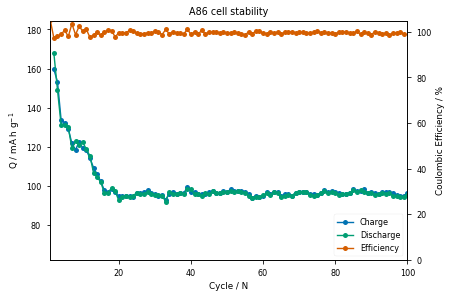

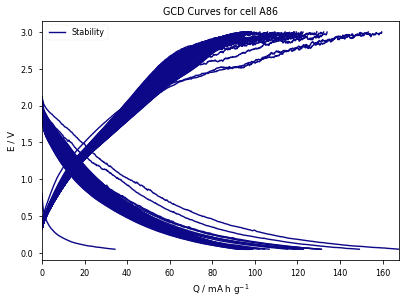

In [27]:
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt

def plot_cycle(file, filename, graphs):
    """Plots charge/discharge capacity and coulombic effeciency vs cycle"""
    df = pd.read_csv(file, delimiter="\t")
    df = df.rename(columns={"RCap_Chg":"Charge","RCap_DChg":"Discharge"})
    graph_title = filename.split("_")[0]+ " cell stability"
    plt.style.use(['seaborn-colorblind', 'seaborn-paper'])
    df = df.drop(df[df['Charge'] == 0].index)  ### skipping values of charge and discharge that are 0 
    df = df.drop(df[df['Discharge'] == 0].index) # due to exporting issues (may be harmful!)
    graph = df.plot(x='Cycle ID', y=['Charge', 'Discharge'], marker="o", markersize=5, title=graph_title)
    graph.set_ylim(df['Charge'].min()-0.33*df['Charge'].min(), df['Discharge'].max()+0.1*df['Discharge'].max())
    if "full" not in filename:
        df['Efficiency'] = df['Discharge']/df['Charge']/100
    df = df.drop(df[df['Efficiency'] < 0.2].index)
    df['Efficiency'].plot(secondary_y=True, marker='o', markersize=5)
    graph.right_ax.set_ylim(0,105)
    graph.right_ax.set_ylabel('Coulombic Efficiency / %')
    graph.set_xlabel("Cycle / N")
    graph.set_ylabel("Q / mA h g$""^{-1}$")
    h1, l1 = graph.get_legend_handles_labels()
    h2, l2 = graph.right_ax.get_legend_handles_labels()
    graph.legend(h1+h2, l1+l2, loc=4)
    graph.get_figure().savefig(os.path.join(pathlib.Path().absolute(),filename)+'.png', dpi=600)


def plot_record(file, filename, graphs):
    """Plots GCD curves"""
    df = pd.read_csv(file, delimiter="\t")
    df = df.rename(columns={'Vol': 'Potential', 'Cur': 'Current', 'Cap': 'Capacity', 'CmpCap': 'Specific Capacity'})
    df_gcd = df[['Step ID', 'Current', 'Specific Capacity', 'Potential']]
    df_gcd['Potential'] = df_gcd['Potential']/1000
    rest_steps = df_gcd[df_gcd['Current'] == 0].index
    df_gcd.drop(rest_steps, inplace=True)
    steps = df_gcd['Step ID'].unique()
    plt.style.use(['seaborn-colorblind', 'seaborn-paper'])
    graph = plt.figure()
    ax = graph.gca() # getting axes so they work as intended when plotting curves
    graph_title = 'GCD Curves for cell ' + filename.split("_")[0]
    for step in steps: 
        df_step = df_gcd.loc[df['Step ID'] == step]
        df_step.plot(ax=ax, x='Specific Capacity', y='Potential', colormap="plasma", title=graph_title)
    ax.legend(['Stability'])
    ax.set_xlabel("Q / mA h g$""^{-1}$")
    ax.set_ylabel("E / V")
    ax.get_figure().savefig(os.path.join(pathlib.Path().absolute(),filename)+'.png', dpi=600)

def csv_to_graph(file, graphs="all"):
    """Send csv's to respective renderers depending on type of data"""
    filename, file_extension = os.path.splitext(file) 
    if file_extension == '.csv': # extract data only from csv files
        if "cycle" in filename:
            plot_cycle(file, filename, graphs)
        elif "record" in filename:
            plot_record(file, filename, graphs)
    else:
        print("Skipping non-csv file...")

def send_files_to_plotter(path):
    """Plot each file in path"""
    if path=="":
      path = os.listdir(pathlib.Path().absolute())
    for file in path:
        csv_to_graph(file, graphs="all")

current_path_contents = os.listdir(pathlib.Path().absolute()) # get files in current folder
send_files_to_plotter(current_path_contents)

Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...


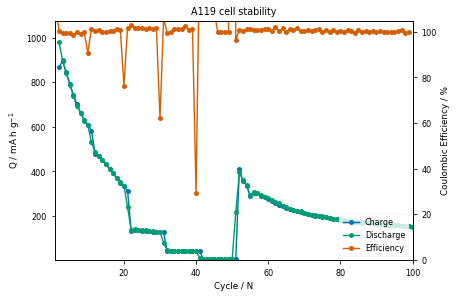

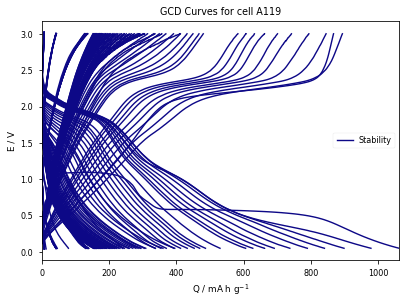

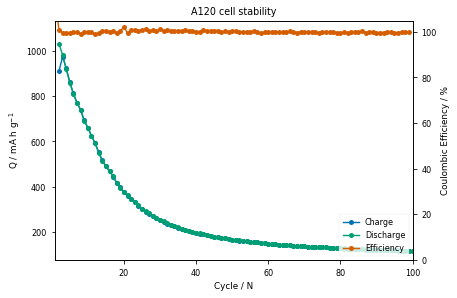

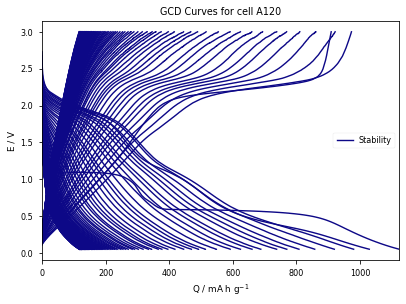

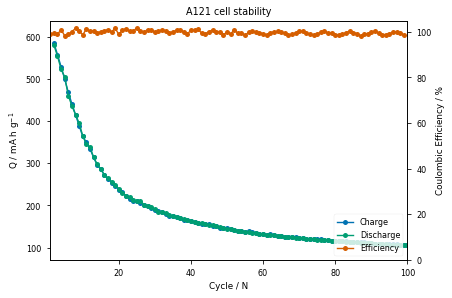

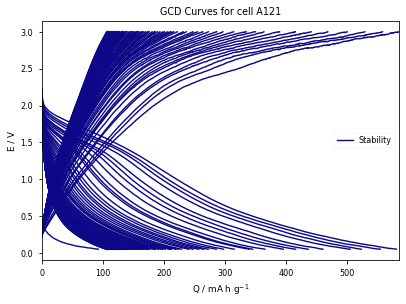

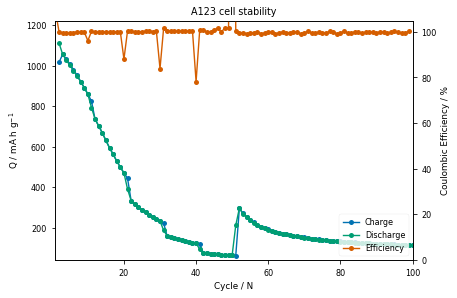

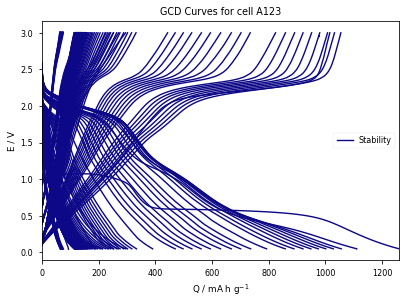

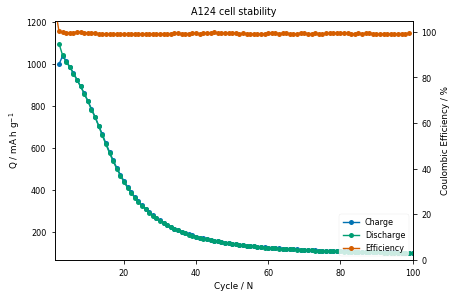

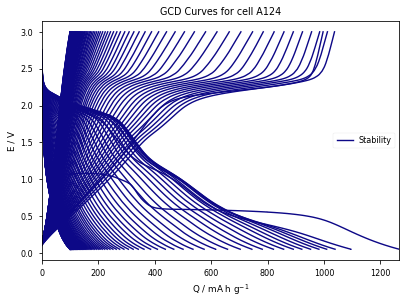

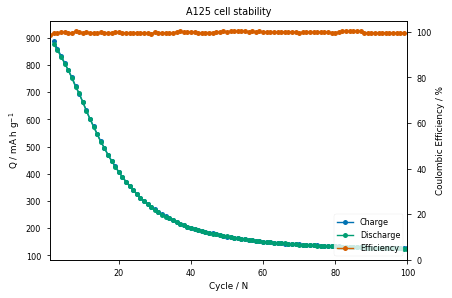

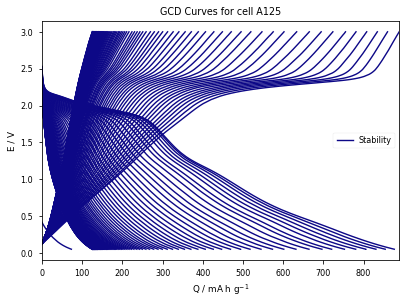

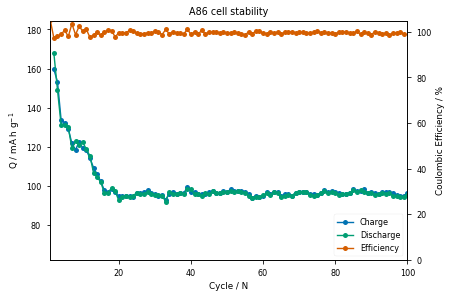

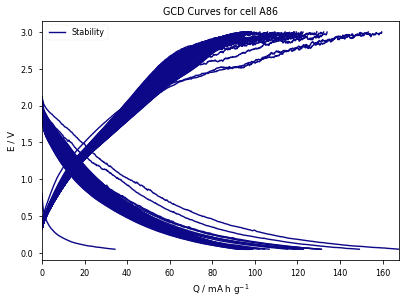

In [32]:
current_path_contents = os.listdir(pathlib.Path().absolute())
send_files_to_plotter(current_path_contents)